In [483]:
# This notebook explores some of the math used for generating SVM signals. It's taken from ST app 
# note AN2154 on applying SVM to an 8-bit microcontroller and extended slightly to operate on a 
# more modern 32-bit MCU with a 32-bit timer. AppNote AVR32710 also has quite a bit of influence.
# It explores generation of the timing signals for sector 0 only, as a playground for myself to 
# understand the math and get a feeling for what influences it.

In [484]:
import math
import numpy as np

In [485]:
# *******************************************************************************
# Various constants and parameters
# *******************************************************************************
# Sampling frequency (Hz). I think this is the overflow rate of the timer, or maybe the time it 
# takes to complete a full up/down count cycle?
Fs = 10000.0

# Elapsed time per counter tick
timer_freq = 60000000.0  # 60 Mhz
tp = 1/timer_freq

# Equation 17: PWM periods
T = 1.0/Fs
T_half = T/2.0

# Timer max value before count down. Divide by two because we have to make two trips before the PWM cycle completes.
tmax = int((timer_freq / Fs) / 2)

# Reference Vectors. This assumes the most significant bit is Phase W and the least significant bit is Phase U.
# This is following the notation used in Figure 2 of AN2154.
V0 = '000' # Null vector, all low side switches enabled
V1 = '001' # 
V2 = '011'
V3 = '010'
V4 = '110'
V5 = '100'
V6 = '101'
V7 = '111' # Null vector, all high side switches enabled

# Sector X Optimal Transition Sequence (least # of gates switching)
sector_x_transition_seq = [
  [V0, V1, V2, V7, V2, V1, V0], # Sector 0
  [V0, V3, V2, V7, V2, V3, V0], # Sector 1
  [V0, V3, V4, V7, V4, V3, V0], # Sector 2
  [V0, V5, V4, V7, V4, V5, V0], # Sector 3
  [V0, V5, V6, V7, V6, V5, V0], # Sector 4
  [V0, V1, V6, V7, V6, V1, V0], # Sector 5
]

# Some constants
pi_div_3 = math.pi/3.0
sqrt_3 = math.sqrt(3.0)

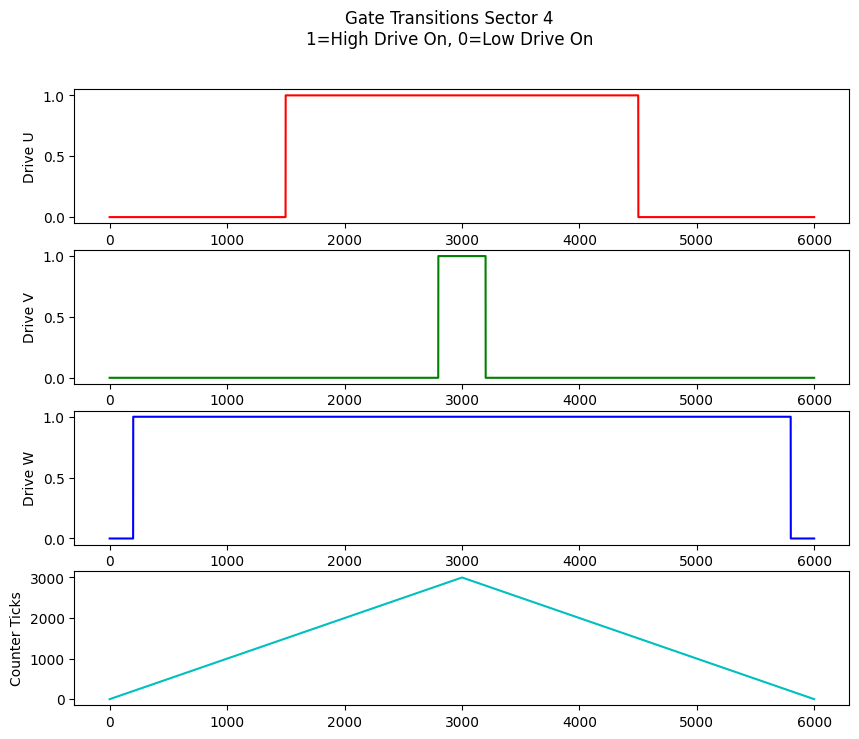

Switch State Transitions:	['000', '100', '101', '111', '101', '100', '000']
Expected Transitions:		['000', '100', '101', '111', '101', '100', '000']


In [486]:
# *******************************************************************************
# User Inputs
# *******************************************************************************
# Electrical angle of the rotor, not absolute physical angle (which depends on motor pole pairs).
target_sector = 4
rotor_theta_elec = math.radians(30.0 + (target_sector * 60.0)) 

# Drive strength (modulation index)
mi = 0.866
assert mi <= sqrt_3/2.0

# *******************************************************************************
# Derived values from user inputs
# *******************************************************************************
# Electrical sector the rotor is currently in
sector = int(rotor_theta_elec / pi_div_3)

# Offset angle from the start of the sector. Must be less than pi/3 due to the 
# SVM algorithm only running on a single sector at a time, which is pi/3 wide.
alpha = rotor_theta_elec - (sector * pi_div_3)
assert alpha < pi_div_3 and alpha >= 0.0

# *******************************************************************************
# Compute the PWM timing signals
# https://github.com/m31L3r/STM32F4_SVPWM/blob/master/src/svpwm.c 
# *******************************************************************************
# Calculate total time in each vector, which is independent of the sector
ta = T_half * mi * math.sin(pi_div_3-alpha) # Time spent in vector A
tb = T_half * mi * math.sin(alpha)          # Time spent in vector B
tn = T_half - ta - tb                       # Time spent in null vector          
tn_half = tn/2.0                            # Time spent in null vector, half cycle

# Compute the capture compare values to generate a particular timing sequence
ton_tn_half = int(tn_half * timer_freq)
ton_1 = int((tn_half + ta) * timer_freq)
ton_2 = int((tn_half + tb) * timer_freq)
ton_3 = int((tn_half + ta + tb) * timer_freq)

# Map the timing information to the phase capture compare registers
if sector == 0:
  phase_u_cc = ton_tn_half
  phase_v_cc = ton_1
  phase_w_cc = ton_3
elif sector == 1:
  phase_u_cc = ton_2
  phase_v_cc = ton_tn_half
  phase_w_cc = ton_3
elif sector == 2:
  phase_u_cc = ton_3
  phase_v_cc = ton_tn_half
  phase_w_cc = ton_1
elif sector == 3:
  phase_u_cc = ton_3
  phase_v_cc = ton_2
  phase_w_cc = ton_tn_half
elif sector == 4:
  phase_u_cc = ton_1
  phase_v_cc = ton_3
  phase_w_cc = ton_tn_half
elif sector == 5:
  phase_u_cc = ton_tn_half
  phase_v_cc = ton_3
  phase_w_cc = ton_2

# *******************************************************************************
# Generate the PWM signals and plot them for visual inspection
# *******************************************************************************
pwm_signals = np.ones((3, 2*tmax), dtype=np.uint32)
ticks = np.zeros((1, 2*tmax), dtype=np.uint32)
tick_values = np.zeros((1, 2*tmax), dtype=np.uint32)

tick = 0
count_up = True
for x in range(2*tmax):
    ticks[0, x] = x
    tick_values[0, x] = tick
    if tick < phase_u_cc:
        pwm_signals[0, x] = 0
    if tick < phase_v_cc:
        pwm_signals[1, x] = 0
    if tick < phase_w_cc:
        pwm_signals[2, x] = 0

    if count_up:
        tick += 1
        count_up = tick < tmax
    else:
        tick -= 1
        count_up = tick == 0

# Plot the PWM signals
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))  # Set the figure size to 10x8 inches
fig.suptitle(f'Gate Transitions Sector {sector}\n1=High Drive On, 0=Low Drive On')

# Create subplot 1
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(ticks[0, :], pwm_signals[0, :], 'r')
ax1.set_ylabel('Drive U')

# Create subplot 2
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(ticks[0, :], pwm_signals[1, :], 'g')
ax2.set_ylabel('Drive V')

# Create subplot 3
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(ticks[0, :], pwm_signals[2, :], 'b')
ax3.set_ylabel('Drive W')

# Create subplot 4
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(ticks[0, :], tick_values[0, :], 'c')
ax4.set_ylabel('Counter Ticks')

plt.show()

# *******************************************************************************
# Validate the PWM signals for accuracy
# *******************************************************************************
# Compute the switch state transitions within the single PWM cycle
binary_values = []

# Iterate over each column
for i in range(pwm_signals.shape[1]):
  # Convert the column to a binary string and then to an integer
  binary_value = ''.join([str(pwm_signals[2, i]), str(pwm_signals[1, i]), str(pwm_signals[0, i])])
  binary_values.append(binary_value)

# Convert the list to a numpy array
binary_values = np.array(binary_values)

# Accumulate the sequence of transitions and the number of ticks in each state
unique_transitions = []
ticks_in_state_x = {}

for i in range(len(binary_values)):
  # If this is the first transition or the transition is different from the previous one, add it to the list
  if i == 0 or binary_values[i] != binary_values[i-1]:
    unique_transitions.append(binary_values[i])

  # If this is the first time we've seen this transition, add it to the dictionary
  if binary_values[i] not in ticks_in_state_x:
    ticks_in_state_x[binary_values[i]] = 1
  else:
    ticks_in_state_x[binary_values[i]] += 1


print(f"Switch State Transitions:\t{unique_transitions}")
print(f"Expected Transitions:\t\t{sector_x_transition_seq[sector]}")
if sector_x_transition_seq[sector] != unique_transitions:
  print(f"ERROR: Transitions do not match expected sequence for sector {sector}")

# Check if only a single bit has changed between each transition
for i in range(len(unique_transitions)-1):
  if bin(int(unique_transitions[i], 2) ^ int(unique_transitions[i+1], 2)).count('1') != 1:
    print(f"ERROR: Invalid transition from {i-1} to {i}")